In [23]:
import numpy as np
import torch
import torch as nn
import pennylane as qml
from pennylane.templates import RandomLayers
import torch.nn as nn
import matplotlib.pyplot as plt

In [24]:
device = torch.device("cpu")

In [72]:
n_qubits = 5

@qml.qnode(qml.device("default.qubit", wires=n_qubits), interface="torch", diff_method="parameter-shift")
def quantum_generator_circuit(noise, gen_weights, gen_n_layers, n_qubits):

    gen_weights = gen_weights.reshape(gen_n_layers, n_qubits)
    print(gen_weights.shape)

    # Encoding layer
    qml.AngleEmbedding(noise, wires=range(n_qubits))

    # PQC layers
    for i in range(gen_n_layers):

        # Rotation gates
        for y in range(n_qubits):
            #for w in range(n_gate_per_layer):
            qml.RX(gen_weights[i][y], wires=y)  
            qml.RY(gen_weights[i][y], wires=y)   
            qml.RZ(gen_weights[i][y], wires=y) 
            #    break 

    #RandomLayers(gen_weights, wires=list(range(n_qubits)), ratio_imprim = 0.1)
    #for i in range(gen_n_layers):

        # Entangling gates
        for y in range(n_qubits - 1):
            qml.CZ(wires=[y, y + 1])

    # Returning probability of each computational basis state
    return qml.probs(wires=list(range(n_qubits)))

In [73]:
gen_n_layers = 3
enc_params = n_qubits
n_gate_per_layer = 3

noise = torch.rand(1, n_qubits)
vqc_weights = torch.rand((gen_n_layers, n_qubits))

torch.Size([3, 5])
(<Figure size 1512x432 with 1 Axes>, <Axes:>)


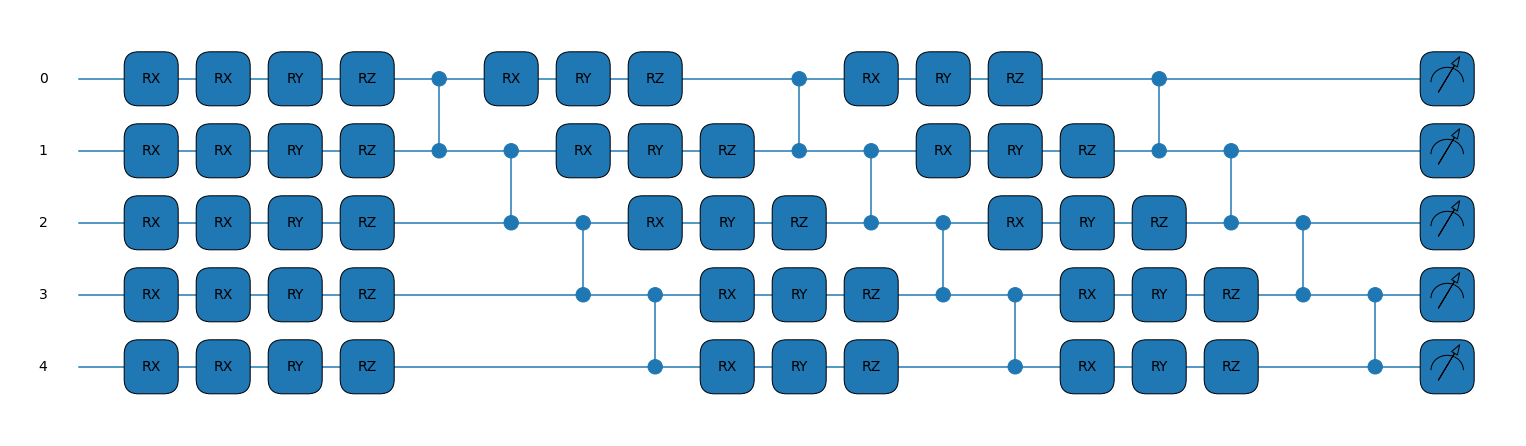

In [74]:
print(qml.draw_mpl(quantum_generator_circuit, expansion_strategy="device")(noise, vqc_weights, gen_n_layers, n_qubits))

torch.Size([3, 5])
torch.Size([3, 5])


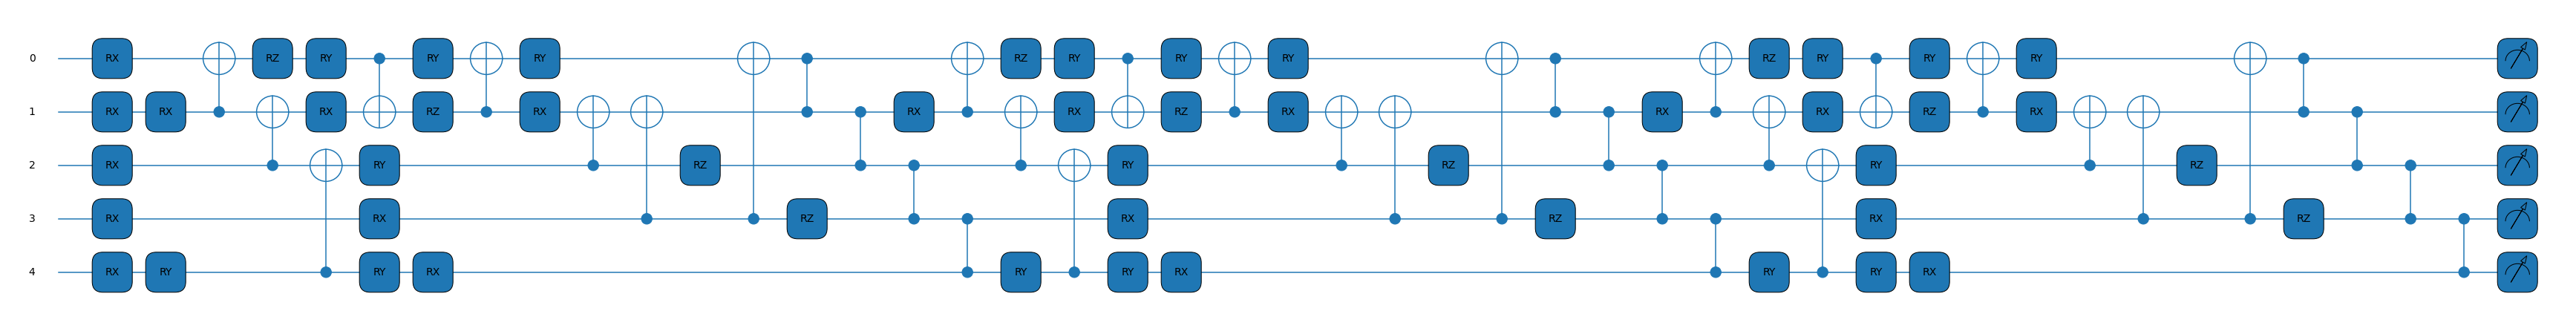

In [17]:
qgc =  quantum_generator_circuit(noise, vqc_weights, gen_n_layers, n_qubits)
qgc.shape
fig, ax = qml.draw_mpl(quantum_generator_circuit, expansion_strategy="device")(noise, vqc_weights, gen_n_layers, n_qubits)
plt.show()

In [18]:
class QuantumGenerator(nn.Module):

    def __init__(self, n_qubits, ancillary_qubits, gen_n_layers, n_generators, device, n_gate_per_layer, q_delta=1):
        super(QuantumGenerator, self).__init__()

        self.n_qubits = n_qubits
        self.ancillary_qubits = ancillary_qubits
        self.gen_n_layers = gen_n_layers
        self.n_gate_per_layer = n_gate_per_layer
        self.n_generators = n_generators
        self.device = device
        self.vqc_params = nn.ParameterList([nn.Parameter(q_delta * torch.rand(self.gen_n_layers * self.n_qubits), 
                                          requires_grad=True)for _ in range(self.n_generators)])

    def forward(self, x):
        
        patch_size = 2 ** (n_qubits - self.ancillary_qubits)

        images = nn.Tensor(x.size(0), 0).to(self.device)

        # Iterate over all sub-generators
        for params in self.vqc_params:
            
            patches = torch.Tensor(0, patch_size).to(self.device)
            for elem in x:

                probs = quantum_generator_circuit(elem, params, self.gen_n_layers, self.n_qubits)
                partial_measure = probs[: (2 ** (n_qubits - self.ancillary_qubits))]
                partial_measure /= torch.sum(probs)
            
                out = partial_measure / torch.max(partial_measure)
                out = out.float().unsqueeze(0)
                patches = torch.cat((patches, out))

            # Building the image
            images = torch.cat((images, patches), 1)
            #print(images.shape)

        return images


In [19]:
ancillary_qubits = 1
n_generators = 4

In [20]:
QuantumGenerator(n_qubits = n_qubits, ancillary_qubits = ancillary_qubits, 
                           gen_n_layers = gen_n_layers, n_generators = n_generators, device = device, 
                           n_gate_per_layer = n_gate_per_layer).to(device)

QuantumGenerator(
  (vqc_params): ParameterList(
      (0): Parameter containing: [torch.FloatTensor of size 15]
      (1): Parameter containing: [torch.FloatTensor of size 15]
      (2): Parameter containing: [torch.FloatTensor of size 15]
      (3): Parameter containing: [torch.FloatTensor of size 15]
  )
)